# Cycle GAN

## Required libraries

In [3]:
# Standard Library Imports
import os
import time

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# PyTorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

# torchvision Imports
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import save_image

# Jupyter Notebook Setting
%matplotlib inline

# Set Random Seed for Reproducibility
torch.manual_seed(0)

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

**NOTE** <br>
The code for CycleGAN is implemented according to the main paper:<br>
Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks, [Link to Paper](https://arxiv.org/abs/1703.10593).<br>
This implementation was created with additional help from the YouTube channel: [\[Aladdin Persson, URL\].](https://www.youtube.com/watch?v=4LktBHGCNfw)

## Dataset

In [5]:
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
                    transforms.Resize((256,256))
])

### Training data

In [6]:
class CalligraphyDataset(Dataset):
    def __init__(self, input_dir, real_dir, transform=False):
        self.input_dir = input_dir
        self.real_dir = real_dir
        self.list_inputs = os.listdir(self.input_dir)
        self.list_reals = os.listdir(self.real_dir)
        self.transform = transform 
        
    def __len__(self):
        return len(self.list_inputs) 
    
    def __getitem__(self, index):
        real_img_file = self.list_reals[index]
        input_img_file = self.list_inputs[index]
        real_image_path = os.path.join(self.real_dir, real_img_file)
        input_image_path = os.path.join(self.input_dir, input_img_file)

        input_image = Image.open(input_image_path)
        real_image = Image.open(real_image_path)

        if self.transform:
          input_image = self.transform(input_image)
          real_image = self.transform(real_image)
        
        return input_image, real_image

In [10]:
# File paths for training data
real_image_path = "data/FarsiDataset/train/Calligraphy"
input_image_path = "data/FarsiDataset/train/std_font"

# Creating training dataset
train_dataset = CalligraphyDataset(input_image_path, real_image_path, transform=transform)

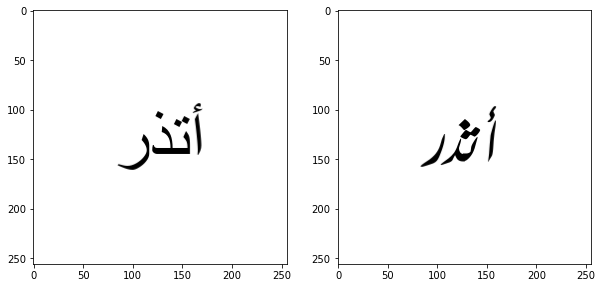

In [11]:
input_image, real_image = dataset[0]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(to_pil_image(0.5*input_image+0.5))
#plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(0.5*real_image+0.5))
#plt.axis('off')

In [12]:
# batch_size = 1
# train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Testing data

In [14]:
# File paths for testing data
real_image_path_val = "data/FarsiDataset/test/Calligraphy"
input_image_path_val = "data/FarsiDataset/test/std_font"

# Creating testing dataset
test_dataset = CalligraphyDataset(input_image_path_val, real_image_path_val, transform=transform)

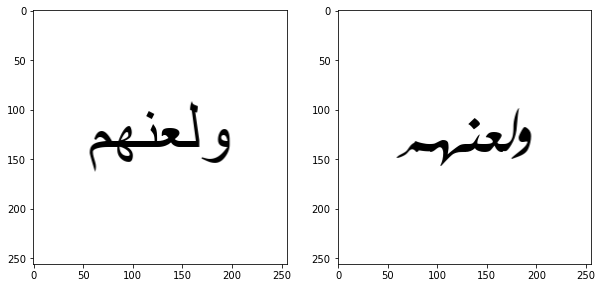

In [15]:
input_image_val, real_image_val = test_dataset[0]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(to_pil_image(0.5*input_image_val+0.5))
#plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(to_pil_image(0.5*real_image_val+0.5))
#plt.axis('off')

In [16]:
batch_size = 1
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Generator

In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        self.res = nn.Sequential(nn.ReflectionPad2d(1),
                                 nn.Conv2d(in_channels, in_channels, 3),
                                 nn.InstanceNorm2d(in_channels),
                                 nn.ReLU(inplace=True),
                                 nn.ReflectionPad2d(1),
                                 nn.Conv2d(in_channels, in_channels, 3),
                                 nn.InstanceNorm2d(in_channels))

    def forward(self, x):
        return x + self.res(x)

### Resnet-based Generator

In [18]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Initial convolution block
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            # Downsampling
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),

            # Residual blocks
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),

            # Upsampling
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            # Output layer
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [19]:
def test():
    img_channels = 3
    img_size = 256
    x = torch.randn((2, img_channels, img_size, img_size), device=device)
    gen = Generator().to(device)
    print(gen(x).shape)
    summary(gen, (3, 256, 256))

test()

torch.Size([2, 3, 256, 256])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 262, 262]               0
            Conv2d-2         [-1, 64, 256, 256]           9,472
    InstanceNorm2d-3         [-1, 64, 256, 256]               0
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-6        [-1, 128, 128, 128]               0
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8          [-1, 256, 64, 64]         295,168
    InstanceNorm2d-9          [-1, 256, 64, 64]               0
             ReLU-10          [-1, 256, 64, 64]               0
  ReflectionPad2d-11          [-1, 256, 66, 66]               0
           Conv2d-12          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-13          [-1, 256, 64, 64]               0
          

## Discriminator

### Conv block

In [20]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            # padding_mode="reflect" help to reduce artifact
            # kernel size = 4
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=True, padding_mode="reflect"),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

### PatchGAN-based Discriminator 

In [21]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4, 
                stride=2, 
                padding=1,
                padding_mode="reflect"
                     ),
            nn.LeakyReLU(0.2)
        )  
        
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels, feature, stride=1 if feature==features[-1] else 2))
            in_channels = feature
        
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))
        self.disc = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.disc(x))

In [22]:
# Run a test to check if the code of disc is correct
def test():
    # 5 examples
    x = torch.randn((5, 3, 256, 256), device=device)
    disc = Discriminator(in_channels=3).to(device)
    preds = disc(x)
    print(preds.shape)
    summary(disc, (3, 256, 256))
    
test()

torch.Size([5, 1, 30, 30])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-4          [-1, 128, 64, 64]               0
         LeakyReLU-5          [-1, 128, 64, 64]               0
             Block-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-8          [-1, 256, 32, 32]               0
         LeakyReLU-9          [-1, 256, 32, 32]               0
            Block-10          [-1, 256, 32, 32]               0
           Conv2d-11          [-1, 512, 31, 31]       2,097,664
   InstanceNorm2d-12          [-1, 512, 31, 31]               0
        LeakyReLU-13          [-1, 512, 31, 31]               0
            

## Parameters

In [23]:
lr = 0.0002
lambda_cycle = 10
lambda_identity = 0.0
num_epochs = 200

In [24]:
disc_a = Discriminator(in_channels=3).to(device) # classify calligraphy images
disc_b = Discriminator(in_channels=3).to(device) # classify standard font images

gen_a = Generator().to(device) # generate calligraphy images
gen_b = Generator().to(device)

opt_disc = optim.Adam(
    list(disc_a.parameters()) + list(disc_b.parameters()),
    lr=lr,
    betas=(0.5, 0.999),
    )

opt_gen = optim.Adam(
    list(gen_a.parameters()) + list(gen_b.parameters()),
    lr=lr,
    betas=(0.5, 0.999),
    )

mse = nn.MSELoss() # adversarial loss
L1 = nn.L1Loss() 

g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

/Users/yousrachahinezhadjazzem/anaconda3/lib/python3.8/site-packages/torch/cuda/amp/grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [25]:
# Weights are initialized from a Gaussian distribution N (0, 0.02)
def initialize_weights(model):
    class_name = model.__class__.__name__
    if class_name.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)

disc_a.apply(initialize_weights);
disc_b.apply(initialize_weights);
gen_a.apply(initialize_weights);
gen_b.apply(initialize_weights);

## Save some eaxmples during training

In [ ]:
def save_some_examples(gen_a, gen_b, val_loader, epoch, folder):
  A, B = next(iter(val_loader))
  A, B = A.to(device), B.to(device)
  gen_a.eval()
  gen_b.eval()
  with torch.no_grad():
    fake_a = gen_a(A) #*******
    fake_b = gen_b(B)

    #fake std font
    fake_a = fake_a * 0.5 + 0.5 # remove normalization
    save_image(fake_a, folder + f"/fake_a_{epoch}.png")
    
    #fake calligraphy
    fake_b = fake_b * 0.5 + 0.5 # remove normalization
    save_image(fake_b, folder + f"/fake_b_{epoch}.png")

    # real input
    save_image(A * 0.5 + 0.5, folder + f"/input_{epoch}.png")
        
    if epoch == 1:
      # real cal
      save_image(B * 0.5 + 0.5, folder + f"/label_{epoch}.png")
  gen_a.train()
  gen_b.train()

## Resume Training

In [ ]:
'''
checkpoint = torch.load(".pt")

gen_a.load_state_dict(checkpoint['gen_a_state_dict'])
gen_b.load_state_dict(checkpoint['gen_b_state_dict'])
disc_a.load_state_dict(checkpoint['disc_a_state_dict'])
disc_b.load_state_dict(checkpoint['disc_b_state_dict'])

opt_gen.load_state_dict(checkpoint['gen_optim'])
opt_disc.load_state_dict(checkpoint['disc_optim'])

gen_a.train()
gen_b.train()

disc_a.train()
disc_b.train()
'''

## Training loop

In [ ]:
since = time.time()   
start_time = time.time()

for epoch in range(num_epochs):
  loop = tqdm(train_loader, leave=True)
  
  # cal -> calligraphy, stdf -> standard font
  for idx, (A, B) in enumerate(loop):
    A = A.to(device)
    B = B.to(device)

    # Train discriminators A and B
    with torch.cuda.amp.autocast():
      fake_B = gen_a(A)
      D_B_fake = disc_b(fake_B.detach())
      D_B_real = disc_b(B)
      D_B_fake_loss = mse(D_B_fake, torch.zeros_like(D_B_fake))
      D_B_real_loss = mse(D_B_real, torch.ones_like(D_B_real))
      D_B_loss = D_B_fake_loss + D_B_real_loss 

      fake_A = gen_b(B)
      D_A_fake = disc_a(fake_A.detach())
      D_A_real = disc_a(A)
      D_A_fake_loss = mse(D_A_fake, torch.zeros_like(D_A_fake))
      D_A_real_loss = mse(D_A_real, torch.ones_like(D_A_real))
      D_A_loss = D_B_real_loss + D_B_fake_loss

      D_loss = (D_A_loss + D_B_loss)/2
  
    opt_disc.zero_grad()
    d_scaler.scale(D_loss).backward()
    d_scaler.step(opt_disc)
    d_scaler.update()

    # train generator G 
    # A --> B
    with torch.cuda.amp.autocast():
      D_A_fake = disc_a(fake_A) 
      D_B_fake = disc_b(fake_B)  
      loss_G_A = mse(D_A_fake, torch.ones_like(D_A_fake))
      loss_G_B = mse(D_B_fake, torch.ones_like(D_B_fake))

      ## Cycle loss
      cycle_a = gen_a(fake_A)
      cycle_b = gen_b(fake_B)
      cycle_a_loss = L1(A, cycle_a)
      cycle_b_loss = L1(B, cycle_b)

      G_loss = (
            loss_G_A  
          + loss_G_B 
          + cycle_a_loss * lambda_cycle
          + cycle_b_loss * lambda_cycle
          )
    opt_gen.zero_grad()
    g_scaler.scale(G_loss).backward()
    g_scaler.step(opt_gen)
    g_scaler.update()

  if (epoch + 1) % 5 == 0:
    torch.save({
        'epoch': epoch,
        'gen_a_state_dict': gen_a.state_dict(),
        'gen_b_state_dict': gen_b.state_dict(),
        'disc_a_state_dict': disc_a.state_dict(),
        'disc_b_state_dict': disc_b.state_dict(),
        'gen_optim': opt_gen.state_dict(),
        'disc_optim': opt_disc.state_dict(),
        }, os.path.join("", 'cycleGAN_farisi_epoch-{}.pt'.format(epoch + 1)))
    
  print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, G_loss.item(), D_loss.item(), (time.time()-start_time)/60))
  save_some_examples(gen_a, gen_b, test_loader, epoch, folder="/data/evalFarisi")

100%|██████████| 14608/14608 [1:22:56<00:00,  2.94it/s]


Epoch: 0, G_Loss: 1.684507, D_Loss: 0.007271, time: 82.94 min


100%|██████████| 14608/14608 [1:23:14<00:00,  2.92it/s]


Epoch: 1, G_Loss: 2.076009, D_Loss: 0.000146, time: 166.18 min


 46%|████▌     | 6668/14608 [37:45<44:48,  2.95it/s]

## Load model for evaluation

In [ ]:
#batch_size = 1
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [73]:
checkpoint = torch.load(".pt", 
                       map_location=torch.device('cpu'))

gen_a.load_state_dict(checkpoint['gen_a_state_dict'])
gen_b.load_state_dict(checkpoint['gen_b_state_dict'])

#  set dropout layers to evaluation mode
gen_a.eval()
gen_b.eval()

# create fake image
with torch.no_grad():
    for a,b in train_loader:
        a, b = a.to(device), b.to(device)
        fake_img = gen_a(a)
        real_img = b
        break

## Visualize generated images

(-0.5, 255.5, 255.5, -0.5)

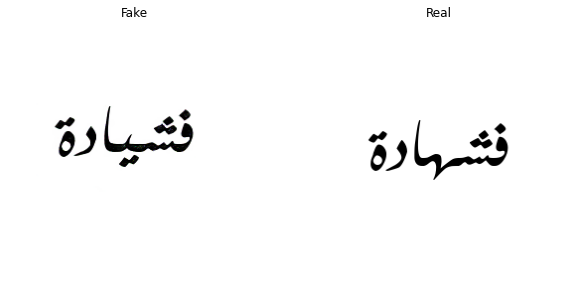

In [74]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(to_pil_image(0.5*np.squeeze(fake_img)+0.5)) # remove normalization
plt.title("Fake")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(to_pil_image(0.5*np.squeeze(real_img)+0.5)) # remove normalization
plt.title("Real")
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

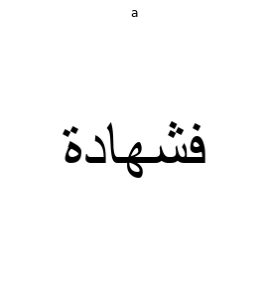

In [75]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,2)
plt.imshow(to_pil_image(0.5*np.squeeze(a)+0.5)) # remove normalization
plt.title("a")
plt.axis('off')